In [12]:
import os
import json
import cv2
from PIL import Image, ImageFilter, ImageEnhance
from shapely.geometry import Polygon


objc[58510]: Class CaptureDelegate is implemented in both /Users/z11241/anaconda3/envs/NLP/lib/libopencv_videoio.4.6.0.dylib (0x107f85240) and /Users/z11241/anaconda3/envs/NLP/lib/python3.8/site-packages/cv2/cv2.abi3.so (0x15f3a63d8). One of the two will be used. Which one is undefined.


In [15]:
# Define the paths to the directories containing the output and ground truth files
output_files_dir = 'out_txt_dir/'
ground_truth_files_dir = 'ann/'

# Function to calculate IoU
def calculate_iou(box1, box2):
    poly1 = Polygon([(box1[0], box1[1]), (box1[2], box1[1]), (box1[2], box1[3]), (box1[0], box1[3])])
    poly2 = Polygon([(box2[0], box2[1]), (box2[2], box2[1]), (box2[2], box2[3]), (box2[0], box2[3])])
    iou = poly1.intersection(poly2).area / poly1.union(poly2).area
    return iou

# Initialize metrics
true_positives, false_positives, false_negatives = 0, 0, 0
ious = []

# Iterate over all output files
for filename in os.listdir(output_files_dir):
    if filename.endswith('.txt'):
        # Construct paths to the output and corresponding ground truth file
        output_file_path = os.path.join(output_files_dir, filename)
        ground_truth_file_path = os.path.join(ground_truth_files_dir, filename.replace('.txt', '.json'))

        # Skip if ground truth file does not exist
        if not os.path.exists(ground_truth_file_path):
            continue

        # Load ground truth data
        with open(ground_truth_file_path, 'r') as gt_file:
            ground_truth_data = json.load(gt_file)

        # Convert ground truth polygons to bounding boxes
        ground_truth_boxes = []
        for obj in ground_truth_data['objects']:
            points = obj['points']['exterior']
            xs, ys = zip(*points)
            x_min, x_max = min(xs), max(xs)
            y_min, y_max = min(ys), max(ys)
            ground_truth_boxes.append((x_min, y_min, x_max, y_max))

        # Load output bounding boxes
        output_boxes = []
        with open(output_file_path, 'r') as out_file:
            for line in out_file:
                x1, y1, x2, y2, x3, y3, x4, y4, _ = map(int, line.split(','))
                x_min, x_max = min(x1, x2, x3, x4), max(x1, x2, x3, x4)
                y_min, y_max = min(y1, y2, y3, y4), max(y1, y2, y3, y4)
                output_boxes.append((x_min, y_min, x_max, y_max))

        # Calculate metrics for each file
        iou_threshold = 0.5
        file_true_positives, file_false_positives, file_false_negatives = 0, 0, 0

        for gt_box in ground_truth_boxes:
            matched = False
            for out_box in output_boxes:
                iou = calculate_iou(gt_box, out_box)
                if iou >= iou_threshold:
                    file_true_positives += 1
                    ious.append(iou)
                    matched = True
                    break
            if not matched:
                file_false_negatives += 1

        file_false_positives = len(output_boxes) - file_true_positives

        true_positives += file_true_positives
        false_positives += file_false_positives
        false_negatives += file_false_negatives

# Calculate overall metrics
precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
average_iou = sum(ious) / len(ious) if ious else 0

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"Average IoU: {average_iou}")


Precision: 0.72083197920052
Recall: 0.35733848880296437
F1 Score: 0.4778112882378284
Average IoU: 0.7821017796934308


Preprocessing: Cropping Bounding Boxes

In [16]:
def find_image_path(base_folder, base_filename, extensions):
    for ext in extensions:
        image_path = os.path.join(base_folder, f"{base_filename}.{ext}")
        if os.path.exists(image_path):
            return image_path, ext
    return None, None

def crop_bounding_boxes(image_folder, annotations_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    extensions = ['jpg', 'jpeg', 'png']

    for filename in os.listdir(annotations_folder):
        if filename.endswith(".txt"):
            txt_path = os.path.join(annotations_folder, filename)
            with open(txt_path, 'r') as file:
                lines = file.readlines()

                base_filename = os.path.splitext(filename)[0]
                image_path, image_ext = find_image_path(image_folder, base_filename, extensions)

                if image_path:
                    image = cv2.imread(image_path)
                    if image is None or not image.size:
                        print(f"Failed to load image: {image_path}")
                        continue

                    image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

                    for i, line in enumerate(lines):
                        coords = [int(x) for x in line.split(',')[:-1]]  # Exclude the label
                        x_coords = coords[0::2]
                        y_coords = coords[1::2]
                        x_min, x_max = min(x_coords), max(x_coords)
                        y_min, y_max = min(y_coords), max(y_coords)

                        if 0 <= x_min < x_max <= image.width and 0 <= y_min < y_max <= image.height:
                            cropped_image = image.crop((x_min, y_min, x_max, y_max))
                            output_filename = f"{base_filename}_{i}.{image_ext}"
                            output_path = os.path.join(output_folder, output_filename)
                            cropped_image.save(output_path)
                        else:
                            print(f"Invalid cropping coordinates for file: {filename}")
                else:
                    print(f"No matching image file found for JSON file: {filename}")

image_folder = "out_vis_dir/"
annotations_folder = "out_txt_dir/"
output_folder = "cropped/"
crop_bounding_boxes(image_folder, annotations_folder, output_folder)


Invalid cropping coordinates for file: 00839.txt
Invalid cropping coordinates for file: 00810.txt
Invalid cropping coordinates for file: 00623.txt
Invalid cropping coordinates for file: 00623.txt
Invalid cropping coordinates for file: 00145.txt
Invalid cropping coordinates for file: 00145.txt
Invalid cropping coordinates for file: 00621.txt
No matching image file found for JSON file: 00812.txt
Invalid cropping coordinates for file: 00806.txt
Invalid cropping coordinates for file: 00379.txt
Invalid cropping coordinates for file: 00386.txt
Invalid cropping coordinates for file: 00386.txt
Invalid cropping coordinates for file: 00393.txt
Invalid cropping coordinates for file: 00393.txt
Invalid cropping coordinates for file: 00393.txt
Invalid cropping coordinates for file: 00393.txt
Invalid cropping coordinates for file: 00436.txt
Invalid cropping coordinates for file: 00191.txt
Invalid cropping coordinates for file: 00191.txt
Invalid cropping coordinates for file: 00191.txt
Invalid croppin

Preprocessing: Greyscaling, Enhancing Contrast, Binarization, Noise Removal

In [17]:
# Define the paths
cropped_images_folder = 'cropped/'
new_prep_folder = 'Preprocessed/'

# Create the new_prep folder if it doesn't exist
if not os.path.exists(new_prep_folder):
    os.makedirs(new_prep_folder)

# Function for preprocessing
def preprocess_image_for_ocr(image):
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Mild contrast enhancement
    alpha = 1.3  # Contrast control (1.0-3.0)
    beta = 0     # Brightness control (0-100)
    adjusted_contrast = cv2.convertScaleAbs(gray_image, alpha=alpha, beta=beta)

    # Binarization
    _, binary_img = cv2.threshold(adjusted_contrast, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Noise removal
    denoised_img = cv2.medianBlur(binary_img, 3)

    return denoised_img

# Process each cropped image
for filename in os.listdir(cropped_images_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(cropped_images_folder, filename)
        image = cv2.imread(image_path)

        # Preprocess the image
        preprocessed_image = preprocess_image_for_ocr(image)

        # Save the preprocessed image
        preprocessed_image_path = os.path.join(new_prep_folder, filename)
        cv2.imwrite(preprocessed_image_path, preprocessed_image)


Use OCR on preprocessed images

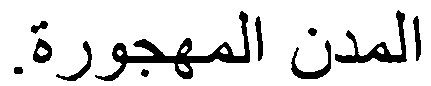

المدن المهجورة.



In [85]:
# Test Tesseract Arabic OCR

'''
brew install tesseract
brew install tesseract-lang  # This will install language support including Arabic
pip install pytesseract
'''

import pytesseract
pytesseract.pytesseract.tesseract_cmd = '/opt/homebrew/bin/tesseract'  # use the path found from your terminal

# test a single image

# Load an image from file
image_path = 'Preprocessed/00514_13.jpg'
image = Image.open(image_path)

# Use Tesseract to do OCR on the image
text = pytesseract.image_to_string(image, lang='ara')
from IPython.display import display

# Display the image
display(image)

# Print the extracted text
print(text)

In [86]:
# Perform Tesseract OCR on dataset

def perform_ocr_on_folder(source_folder, output_file):
    # # Setup Tesseract command
    # pytesseract.pytesseract.tesseract_cmd = '/opt/homebrew/bin/tesseract'

    # Open the output file
    with open(output_file, 'w') as file:
        # Process each image in the source folder
        for filename in os.listdir(source_folder):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(source_folder, filename)
                image = Image.open(image_path)
                text = pytesseract.image_to_string(image, lang='ara')
                file.write(f"Filename: {filename}\n{text}\n\n")

# Directory containing images
source_folder = 'Preprocessed/'
# Output file for OCR results
output_file = 'ocr_results.txt'

perform_ocr_on_folder(source_folder, output_file)

Evaluate OCR Results

In [103]:
# Extract GT labels from JSON files

def extract_gt_labels(json_folder, output_file):
    # Open the output file
    with open(output_file, 'w') as file:
        # Process each JSON file in the folder
        for filename in os.listdir(json_folder):
            if filename.lower().endswith('.json'):
                json_path = os.path.join(json_folder, filename)
                with open(json_path, 'r') as json_file:
                    data = json.load(json_file)
                    # Extract 'value' from 'tags' and associate with image filename
                    for obj in data.get("objects", []):
                        for tag in obj.get("tags", []):
                            value = tag.get("value", "")
                            # Construct image filename (change extension as needed)
                            image_filename = os.path.splitext(filename)[0] + '.jpg'  # Change '.jpg' to the correct extension
                            file.write(f"Filename: {image_filename}\n{value}\n\n")

# Directory containing JSON files
json_folder = 'ann/'
# Output file for GT labels
output_file = 'gt_labels.txt'

extract_gt_labels(json_folder, output_file)

In [107]:
def compare_ocr_with_ground_truth(ocr_file, gt_file):
    # Read and store OCR results and ground truth labels
    with open(ocr_file, 'r') as file:
        ocr_results = file.read().split('\n\n')
    with open(gt_file, 'r') as file:
        gt_labels = file.read().split('\n\n')

    # Process OCR results and accumulate GT labels for each main filename
    ocr_dict = {res.split('\n')[0]: ' '.join(res.split('\n')[1:]).strip() for res in ocr_results if res}
    gt_accumulated = {}
    for label in gt_labels:
        if label:
            lines = label.split('\n')
            filename = lines[0].split('.')[0]
            gt_text = ' '.join(lines[1:]).strip()
            gt_accumulated[filename] = gt_accumulated.get(filename, '') + ' ' + gt_text

    # Compare and evaluate
    correct = 0
    total = 0
    for file_label, ocr_text in ocr_dict.items():
        base_file_label = file_label.split('_')[0]
        gt_text = gt_accumulated.get(base_file_label, "").split()
        total += 1
        matching_words = [word for word in ocr_text.split() if word in gt_text]
        if matching_words:
            correct += 1
            print(f"Match: {file_label}\nMatching Text: {' '.join(matching_words)}\n")

    # Calculate accuracy
    accuracy = correct / total if total > 0 else 0
    print(f"\nAccuracy: {accuracy:.2f} ({correct}/{total})")

# Paths to your OCR results and ground truth files
ocr_file = 'ocr_results.txt'
gt_file = 'gt_labels.txt'

compare_ocr_with_ground_truth(ocr_file, gt_file)


Match: Filename: 00604_1.jpg
Matching Text: موسوعة التوابل

Match: Filename: 00372_4.jpg
Matching Text: المحلية

Match: Filename: 00542_1.jpeg
Matching Text: الخطة البراقة

Match: Filename: 00359_2.jpg
Matching Text: التفكير الابتكاري

Match: Filename: 00346_5.jpg
Matching Text: في


Accuracy: 0.02 (5/266)
